<a href="https://colab.research.google.com/github/linhoangce/pytorch_crash_course/blob/main/pytorch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [2]:
# setup device-agnostic device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi

Wed Jun 25 03:58:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

This dataset is a subset of the Food101 dataset, which has 101 different classes of food and 1000 images per class (750 training, 250 testing)

The dataset we're using here only has 3 classes of food and only 10% of the images.

The purpose is to try training on a small scale first and scale it up later.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data")
image_path = data_path / "pizza_sushi_steak"

# check if the folder exists before downloading
if image_path.is_dir():
  print("data folder exists")
else:
  print(f"{image_path} does not exist, downloading...")
  image_path.mkdir(parents=True, exist_ok=True)

# download the dataset
with open(data_path / "pizza_sushi_steak.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza_sushi_steak.zip...")
  f.write(request.content)

# unzip data
with zipfile.ZipFile(data_path / "pizza_sushi_steak.zip", 'r') as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(image_path)

data/pizza_sushi_steak does not exist, downloading...
Unzipping data...


## 2. Preprare data

In [5]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_sushi_steak'
There are 3 directories and 0 images in 'data/pizza_sushi_steak/test'
There are 0 directories and 19 images in 'data/pizza_sushi_steak/test/steak'
There are 0 directories and 31 images in 'data/pizza_sushi_steak/test/sushi'
There are 0 directories and 25 images in 'data/pizza_sushi_steak/test/pizza'
There are 3 directories and 0 images in 'data/pizza_sushi_steak/train'
There are 0 directories and 75 images in 'data/pizza_sushi_steak/train/steak'
There are 0 directories and 72 images in 'data/pizza_sushi_steak/train/sushi'
There are 0 directories and 78 images in 'data/pizza_sushi_steak/train/pizza'


In [6]:
# Setup train and testing path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_sushi_steak/train'),
 PosixPath('data/pizza_sushi_steak/test'))

### 2.1 Visualize an image


1. GEt all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. GEt the image class anme using `pathlib.Path.parent.stem`
4. Using Python's PIL lib to open images



In [7]:
import random
from PIL import Image

# Set random seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list

[PosixPath('data/pizza_sushi_steak/test/steak/673127.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1868005.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1285886.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1302563.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1016217.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/100274.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/2144308.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1627703.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/3424937.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/354513.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1882831.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/894825.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/2117351.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/296375.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/27415.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/690177.jpg'),
 PosixPath('data/pizza_sushi_ste

In [8]:
# 2. pick a random image path
random_image_path = random.choice(image_path_list)
random_image_path

PosixPath('data/pizza_sushi_steak/test/pizza/714866.jpg')

In [9]:
# 3. Get image class from path name
# the image class is the name of the dir where the image is from
image_class = random_image_path.parent.stem
image_class

'pizza'

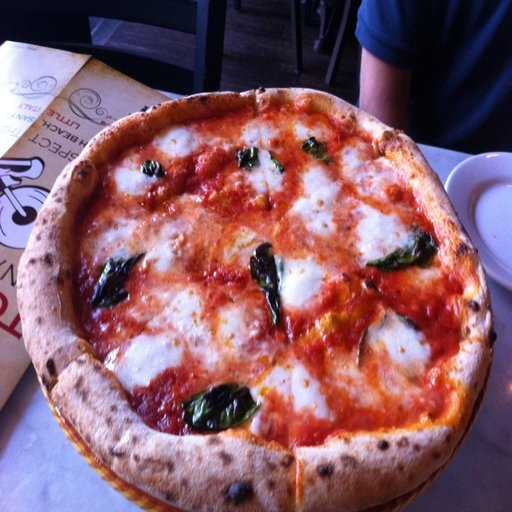

In [10]:
# 4. open image
img = Image.open(random_image_path)
img

In [11]:
# 5. print metadata
print(f"image height: {img.height}")
print(f"image width: {img.width}")

image height: 512
image width: 512


array([[[  9,   6,  25],
        [  9,   6,  25],
        [  9,   8,  26],
        ...,
        [ 18,  25,  71],
        [ 16,  21,  63],
        [ 13,  16,  57]],

       [[ 12,   9,  28],
        [ 12,   9,  28],
        [ 11,  10,  28],
        ...,
        [ 18,  25,  69],
        [ 16,  19,  60],
        [ 12,  16,  54]],

       [[ 13,  10,  29],
        [ 13,  10,  29],
        [ 12,  11,  29],
        ...,
        [ 16,  23,  65],
        [ 13,  17,  54],
        [ 10,  13,  48]],

       ...,

       [[177, 176, 244],
        [177, 176, 244],
        [173, 172, 240],
        ...,
        [ 58,  39,  59],
        [ 60,  38,  59],
        [ 60,  38,  59]],

       [[176, 177, 244],
        [175, 176, 243],
        [171, 170, 238],
        ...,
        [ 59,  40,  60],
        [ 61,  39,  60],
        [ 60,  38,  59]],

       [[173, 174, 241],
        [173, 174, 241],
        [171, 170, 238],
        ...,
        [ 58,  39,  59],
        [ 61,  39,  60],
        [ 60,  38,  59]]], dtype=uint8)
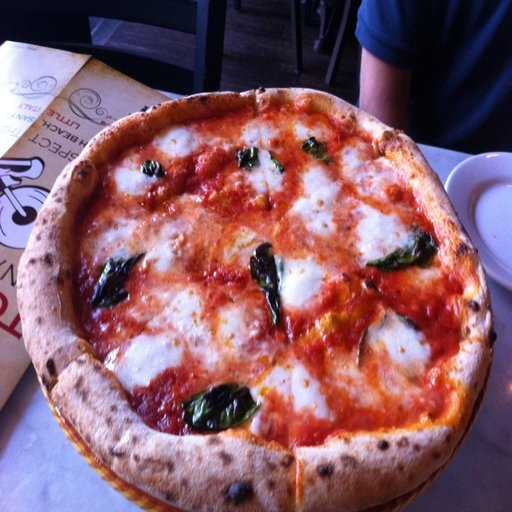

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# turn image into array
img_as_array = np.asarray(img)
img_as_array

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

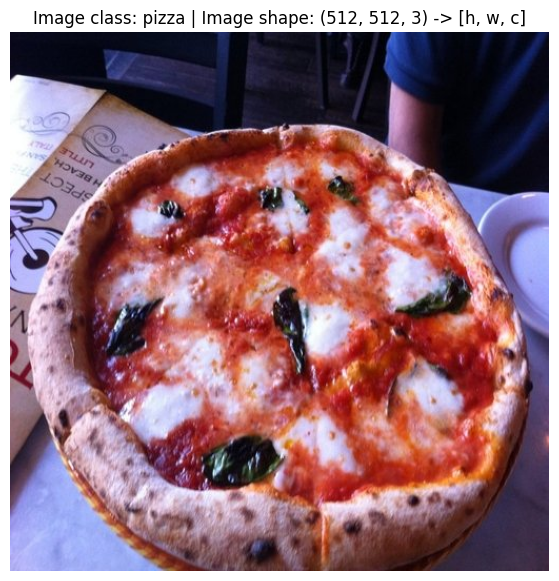

In [13]:
# plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [h, w, c]")
plt.axis(False)

## 3. Transform data

> Add blockquote



Before using image data with PyTorch:

1. Turn target data into tensors (numerical representation of the images in pixels)
2. Turn data into `torch.utils.data.Dataset` and subsequently `torch.utils.data.DataLoader`

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transform data with `torchvision.transform`

In [15]:
# 1. Write a transform for image
data_transform = transforms.Compose([
    # resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Trun the image into a torch.Tensor
    transforms.ToTensor()
])

In [16]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [17]:
data_transform(img).dtype

torch.float32

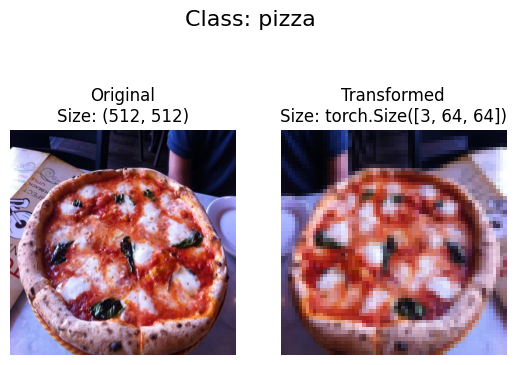

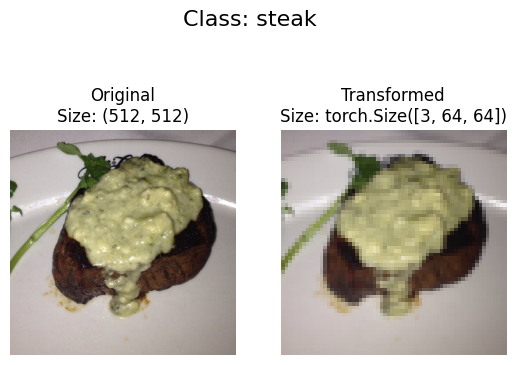

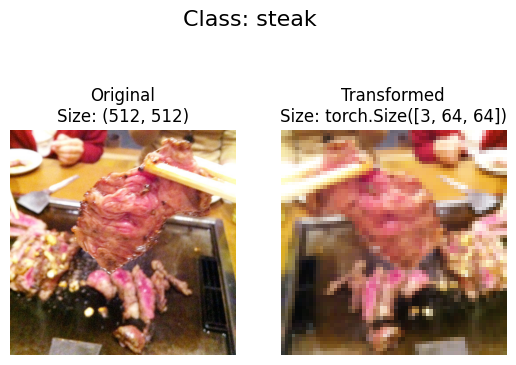

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """Selects  random images from a path and loads/transforms them then plots the original vs the transformed images"""

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f)
      ax[1].imshow(transformed_image.permute(1, 2, 0)) # matplotlib works with c-h-w
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data uisng `torchvision.datasets.ImageFolder`

In [19]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for features
                                  target_transform=None) # transformfor label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_sushi_steak/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_sushi_steak/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
# Get class name as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [21]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
# check length of datasets
len(train_data), len(test_data)

(225, 75)

In [23]:
train_data.samples[100]

('data/pizza_sushi_steak/train/steak/1976160.jpg', 1)

In [24]:
# Index on the train_data Dataset to get a single image and label
train_data[100]

(tensor([[[0.9804, 0.9725, 0.9490,  ..., 0.8824, 0.8784, 0.8824],
          [0.9725, 0.9569, 0.9294,  ..., 0.8784, 0.8824, 0.8863],
          [0.9608, 0.9451, 0.9294,  ..., 0.8824, 0.8863, 0.8824],
          ...,
          [0.6627, 0.6588, 0.6588,  ..., 0.6588, 0.6627, 0.6706],
          [0.6980, 0.6627, 0.6627,  ..., 0.6588, 0.6627, 0.6667],
          [0.8039, 0.7020, 0.6667,  ..., 0.6588, 0.6549, 0.6706]],
 
         [[0.8118, 0.8000, 0.7569,  ..., 0.7686, 0.7725, 0.7765],
          [0.8039, 0.7843, 0.7490,  ..., 0.7686, 0.7686, 0.7725],
          [0.8000, 0.7765, 0.7529,  ..., 0.7686, 0.7686, 0.7686],
          ...,
          [0.5255, 0.5255, 0.5294,  ..., 0.5608, 0.5608, 0.5608],
          [0.5608, 0.5333, 0.5333,  ..., 0.5608, 0.5608, 0.5608],
          [0.6706, 0.5725, 0.5333,  ..., 0.5608, 0.5608, 0.5686]],
 
         [[0.6471, 0.6431, 0.6118,  ..., 0.6980, 0.7020, 0.6980],
          [0.6471, 0.6235, 0.6039,  ..., 0.6980, 0.7020, 0.7020],
          [0.6549, 0.6275, 0.6078,  ...,

In [25]:
img, label = train_data[100][0], train_data[100][1]
img

tensor([[[0.9804, 0.9725, 0.9490,  ..., 0.8824, 0.8784, 0.8824],
         [0.9725, 0.9569, 0.9294,  ..., 0.8784, 0.8824, 0.8863],
         [0.9608, 0.9451, 0.9294,  ..., 0.8824, 0.8863, 0.8824],
         ...,
         [0.6627, 0.6588, 0.6588,  ..., 0.6588, 0.6627, 0.6706],
         [0.6980, 0.6627, 0.6627,  ..., 0.6588, 0.6627, 0.6667],
         [0.8039, 0.7020, 0.6667,  ..., 0.6588, 0.6549, 0.6706]],

        [[0.8118, 0.8000, 0.7569,  ..., 0.7686, 0.7725, 0.7765],
         [0.8039, 0.7843, 0.7490,  ..., 0.7686, 0.7686, 0.7725],
         [0.8000, 0.7765, 0.7529,  ..., 0.7686, 0.7686, 0.7686],
         ...,
         [0.5255, 0.5255, 0.5294,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5333, 0.5333,  ..., 0.5608, 0.5608, 0.5608],
         [0.6706, 0.5725, 0.5333,  ..., 0.5608, 0.5608, 0.5686]],

        [[0.6471, 0.6431, 0.6118,  ..., 0.6980, 0.7020, 0.6980],
         [0.6471, 0.6235, 0.6039,  ..., 0.6980, 0.7020, 0.7020],
         [0.6549, 0.6275, 0.6078,  ..., 0.6863, 0.6980, 0.

In [26]:
label

1

In [27]:
img.shape

torch.Size([3, 64, 64])

In [28]:
class_names[label]

'steak'

In [29]:
# rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

img.shape, img_permute.shape

(torch.Size([3, 64, 64]), torch.Size([64, 64, 3]))

### 4.1 Turn loaded images into `DataLoader

In [30]:
import os

os.cpu_count()

2

In [31]:
# turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count())
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d946025d910>,
 <torch.utils.data.dataloader.DataLoader at 0x7d9460483590>)

In [32]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option2 : Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from Dataset
3. Want to be able to get classes as dictionary from Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
*Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using a custom `Dataset` often results in us rewriting more code, which could be prone to errors or performance issue1111

In [33]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [34]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [35]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

Target dir: data/pizza_sushi_steak/train


In [36]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [37]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Ffinds the class folder names in target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [38]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclasses with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open images
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [39]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass `torch.utils.data.Dataset`
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_images(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite `__len__()`
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_images(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [40]:
img, label = train_data[0]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [41]:
# Create a transfrom
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [42]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [43]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d946009c910>,
 <__main__.ImageFolderCustom at 0x7d9460095550>)

In [44]:
len(train_data), len(train_data_custom)

(225, 225)

In [45]:
len(test_data), len(test_data_custom)

(75, 75)

In [46]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [47]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [48]:
# Check for equality between original ImageFolder and ImageFolderCustom
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indices and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)



In [49]:
# 1. Create a function to tak ein a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indices and plit them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [channel, height, width] -> [height, width, channels]

    # plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

In [50]:
random.sample(range(len(train_data_custom)), k=10)

[62, 57, 35, 188, 26, 173, 189, 139, 22, 151]

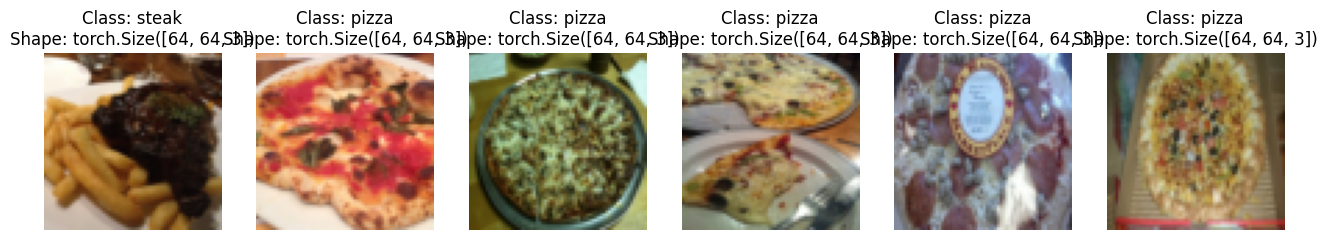

In [51]:
# display random images from ImageFolder
display_random_images(dataset=train_data,
                      n=6,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10


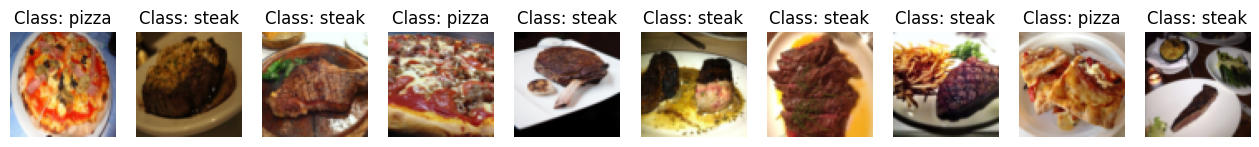

In [52]:
# display random images from ImageFolderCustom dataset
display_random_images(dataset=train_data_custom,
                      classes=class_names,
                      n=20,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`

In [53]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloder_custom = DataLoader(dataset=test_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d946009c910>,
 <__main__.ImageFolderCustom at 0x7d9460095550>)

In [54]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diverisity to your training data.

For images, this means applying various image transformation to the training images.

This practice hopefully results in model that's more generalizable to unseen data.

In [55]:
# TrivialAument
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [56]:
# Get all image paths
image_path_lists = list(image_path.glob("*/*/*.jpg"))
image_path_lists[:10]

[PosixPath('data/pizza_sushi_steak/test/steak/673127.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1868005.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1285886.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1302563.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1016217.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/100274.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/2144308.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/1627703.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/3424937.jpg'),
 PosixPath('data/pizza_sushi_steak/test/steak/354513.jpg')]

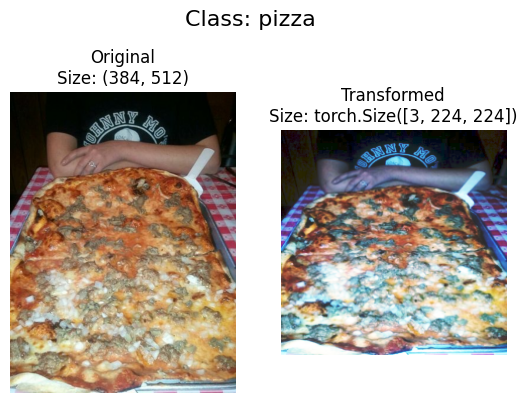

In [57]:
# plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Create transforms and load data

In [58]:
# Create simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [59]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                            )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

## 7.2 Create TinyVGG model class

In [60]:
class TinyVGG(nn.Module):
  """Replicate TinyVGG model architecture from CNN Explainer website."""
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # this speeds up computation
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [61]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [62]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [63]:
model_0.to(device)
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [64]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


In [65]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loop functions

In [66]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # move model to target device
  model.to(device)

  # Turn on train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # loop dataloader data batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # forward pass
    y_logits = model(X)
    y_pred = torch.argmax(y_logits, dim=1)

    # loss calculation
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    # backward pass
    loss.backward()

    optimizer.step()

    # calculate accuracy
    train_acc += (y_pred == y).sum().item() / len(y_logits)

  # adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [67]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # move model to target device
  model.to(device)

  # turn on eval mode
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_logits = model(X)
      test_pred = torch.argmax(test_logits, dim=1)

      loss = loss_fn(test_logits, y)
      test_loss += loss.item()
      test_acc += (test_pred==y).sum().item() / len(test_logits)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

### 7.6 Create a `train` function to combine `train_step` and `test_step`

In [68]:
from tqdm.auto import tqdm

In [69]:
# 1. Create a train function that takes in various model parameters + optimizers + dataloader
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: torch.device = device):
  # Create empty result dicts
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print what's happening
    print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")

    # 5. Update result dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


### 7.7 Train and evaluate model 0

In [70]:
from timeit import default_timer as timer

In [71]:
torch.manual_seed(42)

EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start timer
start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)
end_time = timer()
train_time_model_0 = end_time - start_time

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 | Train loss: 1.1063 | Train acc: 0.30 | Test loss: 1.0983 | Test acc: 0.30
Epoch 1 | Train loss: 1.0998 | Train acc: 0.33 | Test loss: 1.0697 | Test acc: 0.54
Epoch 2 | Train loss: 1.0869 | Train acc: 0.49 | Test loss: 1.0808 | Test acc: 0.49
Epoch 3 | Train loss: 1.0845 | Train acc: 0.40 | Test loss: 1.0607 | Test acc: 0.58
Epoch 4 | Train loss: 1.0663 | Train acc: 0.42 | Test loss: 1.0656 | Test acc: 0.56


In [72]:
train_time_model_0

10.14677410400003

In [73]:
model_0_results

{'train_loss': [1.1063193678855896,
  1.099782943725586,
  1.086904600262642,
  1.0844976007938385,
  1.0663105100393295],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.421875],
 'test_loss': [1.0983216762542725,
  1.069722851117452,
  1.080820361773173,
  1.060702959696452,
  1.065629005432129],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves of Model 0

A **loss curves** is a way of tracking model results over time

In [74]:
# Get model_0_result keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [75]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plot training and testing result."""
  # GEt the loss values of the results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values
  accuracy = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

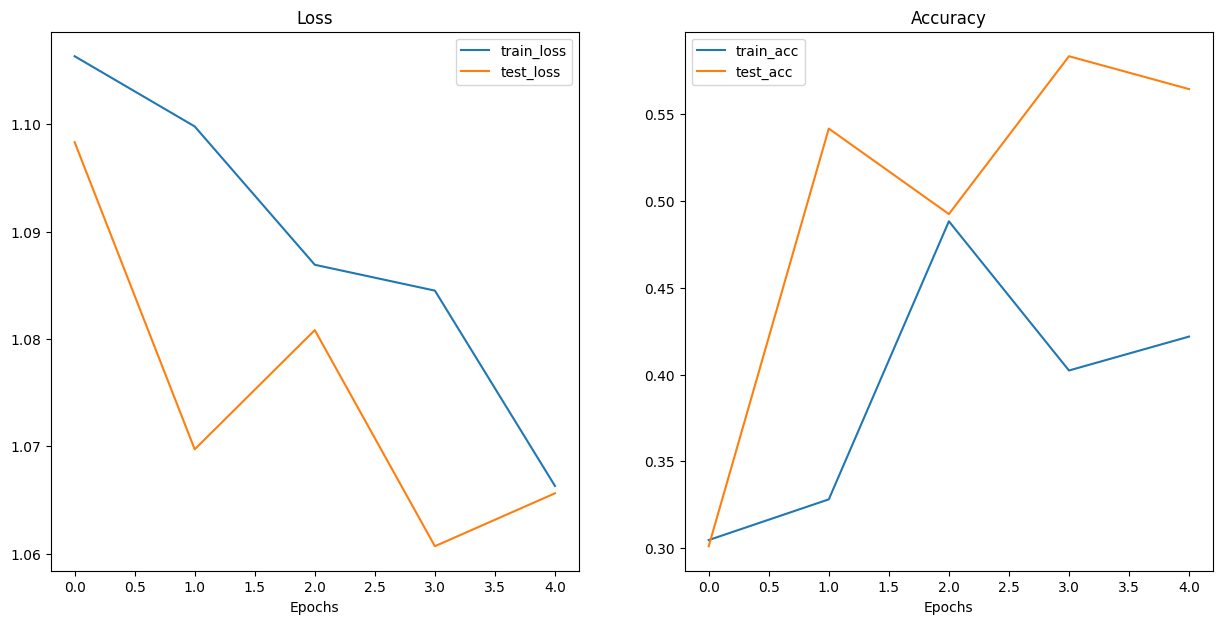

In [76]:
plot_loss_curves(model_0_results)

## 8. Interpreting Loss Curves

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [77]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader` with data augmentation

In [78]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                           transform=test_transform_simple)

In [79]:
# Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1



In [80]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=100,
                  output_shape=(len(train_data_augmented.classes)))
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16900, out_features=3, bias=True)
  )
)

In [81]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Training
start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)
end_time = timer()

train_time_model_1 = end_time - start_time
train_time_model_1

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 | Train loss: 1.1496 | Train acc: 0.38 | Test loss: 1.1255 | Test acc: 0.26
Epoch 1 | Train loss: 1.0911 | Train acc: 0.43 | Test loss: 1.1405 | Test acc: 0.26
Epoch 2 | Train loss: 1.0860 | Train acc: 0.43 | Test loss: 1.1333 | Test acc: 0.26
Epoch 3 | Train loss: 1.1166 | Train acc: 0.30 | Test loss: 1.1342 | Test acc: 0.26
Epoch 4 | Train loss: 1.0960 | Train acc: 0.30 | Test loss: 1.1181 | Test acc: 0.20


8.061453927999992

In [82]:
model_1_results

{'train_loss': [1.1495670974254608,
  1.0911194384098053,
  1.0859753713011742,
  1.116564765572548,
  1.0959660857915878],
 'train_acc': [0.3828125, 0.42578125, 0.42578125, 0.3046875, 0.30078125],
 'test_loss': [1.1254967053731282,
  1.1405491431554158,
  1.1333172917366028,
  1.1342369715372722,
  1.1181185245513916],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.19791666666666666]}

In [83]:
!nvidia-smi

Wed Jun 25 03:59:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P0             32W /   70W |     708MiB /  15360MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

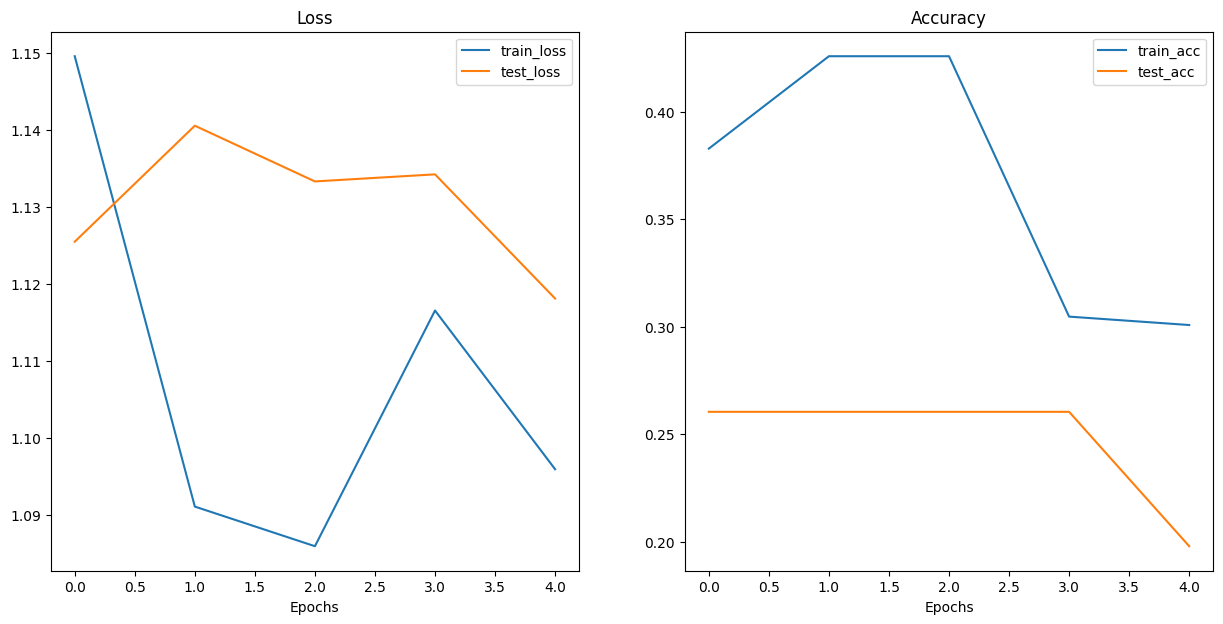

In [84]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [85]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098322  0.301136
1    1.099783   0.328125   1.069723  0.541667
2    1.086905   0.488281   1.080820  0.492424
3    1.084498   0.402344   1.060703  0.583333
4    1.066311   0.421875   1.065629  0.564394

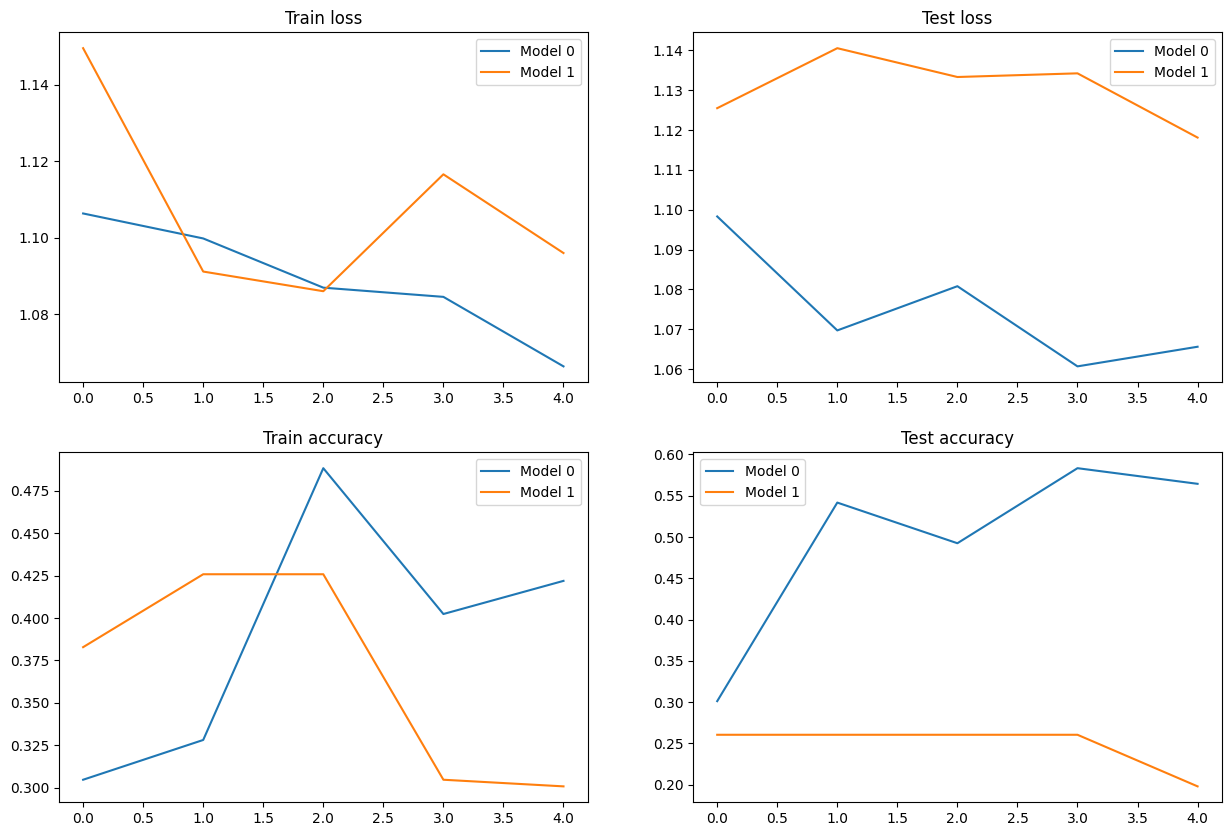

In [86]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.legend()

# plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.legend()

# plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.legend()

## 11. Making a prediction on a custom image

In [87]:
# download custom image
import requests

# setup custom image path
custom_image_path = data_path / "custom_image.jpg"

# download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading {request.url}....")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

### 11.1 Loading a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

In [88]:
import torchvision

# read custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

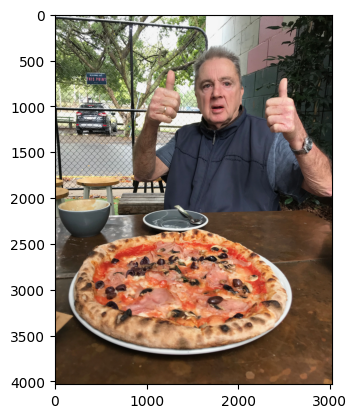

In [89]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [90]:
custom_image_uint8.shape

torch.Size([3, 4032, 3024])

In [91]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8)

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [92]:
# convert image data to torch.float32
custom_image_float32 = custom_image_uint8.type(torch.float32)
custom_image_float32.dtype

torch.float32

In [93]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_float32.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x756765 and 16900x3)

In [94]:
# transform custom image to 64x64x3
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))])

In [95]:
custom_image_transformed = custom_image_transform(custom_image_float32)
custom_image_transformed

tensor([[[119.1508, 134.9383, 142.8357,  ...,  24.8991,  15.4060,  14.7357],
         [102.3608, 110.9618, 109.4176,  ...,  17.1072,  18.2024,  21.6332],
         [131.8788, 123.6541, 114.0285,  ...,  15.6425,  15.4303,  17.6984],
         ...,
         [ 76.4723,  71.8883,  68.9893,  ..., 116.5282, 102.4844, 100.8483],
         [ 70.5540,  68.7793,  66.4534,  ..., 117.8215, 107.3131,  95.9460],
         [ 63.8126,  65.1965,  68.6048,  ..., 124.8078, 155.2424, 136.2767]],

        [[125.6219, 140.6797, 147.2064,  ...,  31.7760,  17.5512,  17.3307],
         [115.9080, 124.3301, 117.3026,  ...,  20.5561,  21.0223,  26.0550],
         [139.8677, 133.0331, 122.0205,  ...,  17.5746,  17.9564,  22.4882],
         ...,
         [ 52.6926,  50.2704,  47.9802,  ...,  79.6936,  70.6929,  70.8279],
         [ 49.0124,  47.6833,  46.0160,  ...,  82.0215,  74.6160,  67.8931],
         [ 44.1253,  45.3032,  47.5500,  ...,  87.3388, 107.6761,  93.9483]],

        [[114.9933, 133.8631, 143.3564,  ...

In [96]:
custom_image_float32.shape, custom_image_transformed.shape

(torch.Size([3, 4032, 3024]), torch.Size([3, 64, 64]))

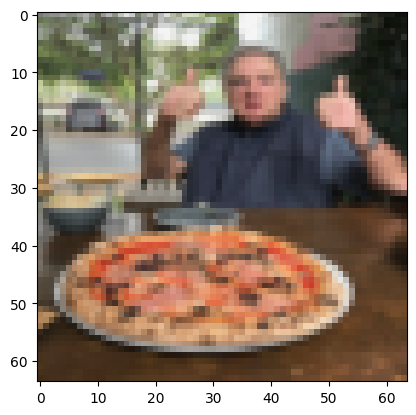

In [97]:
# Normalize the transformed image to the range [0, 1] for plotting
custom_image_transformed_normalized = custom_image_transformed / 255.0

plt.imshow(custom_image_transformed_normalized.permute(1, 2, 0))

In [98]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x169 and 16900x3)

In [99]:
# Add a batch size to the image input
custom_image_batch = custom_image_transformed.unsqueeze(dim=0)
custom_image_batch.shape

torch.Size([1, 3, 64, 64])

In [100]:
model_1.eval()
with torch.inference_mode():
  logits = model_1(custom_image_batch.to(device))
  print(torch.argmax(logits, dim=1).item())

class_names[torch.argmax(logits, dim=1).item()]

0


'pizza'

### Functionize custom image transformation

In [101]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # move model to target device
  model.to(device)

  # Load image
  target_image = torchvision.io.read_image(image_path).type(torch.float32)

  # Divide image pixel vaues by 255 to normalize in range 0-1
  target_image = target_image / 255.

  # transform if necessary
  if transform:
    target_image = transform(target_image)

  # Turn on eval mode and make predictions
  model.eval()
  with torch.inference_mode():
    # add batch
    target_image = target_image.unsqueeze(0)
    # move to device
    target_image = target_image.to(device)

    # make preidction
    logits = model(target_image)

  # convert logits -> probs
  probs = torch.softmax(logits, dim=1)

  # convert to labels (with either logits or probs)
  y_pred = torch.argmax(probs, dim=1)

  # plot the image vs prediction and probs
  plt.imshow(target_image.squeeze(0).permute(1, 2, 0).cpu()) # remove batch dim

  if class_names:
    title = f"Pred: {class_names[y_pred.cpu()]} | Prob: {probs.max().cpu():.3f}"
  else:
    title = f"Pred: {y_pred.cpu()} | Prob: {probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

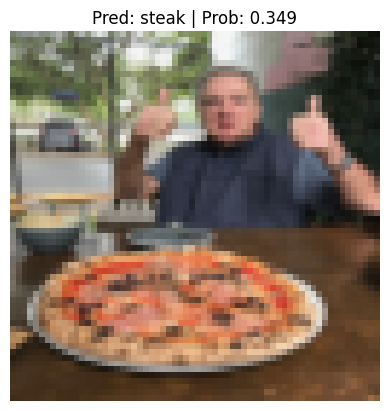

In [102]:
pred_and_plot_image(model=model_1,
                    image_path=str(custom_image_path),
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)